# Pipeline for Ca-Data-Preprocessing and Analysis

# Calcium Imaging preprocessing
---
* Author: Yue Zhang and David Burkhardt (AG Arrenberg)
* date: 17/04/2023

In [1]:
# import libraries
from skimage import io
import os
import numpy as np
from PyQt5.QtWidgets import QFileDialog, QApplication

# from Exp4_for_test_data import * # use Exp4_for_test_data for running test data
from Exp4 import * # use Exp4 for running your own data

# %matplotlib notebook
%matplotlib inline 
import matplotlib.pyplot as plt

In [2]:
working_dir = 'testdata_2024'
ca_filename = "ca_recording.tif"
ca_filename2 = "ca_recording2.tif"
timeline_filename = "Io.hdf5"
stimulus_filename = "Display.hdf5"

In [4]:
# load calcium data
ca_movie = load_ca_movie(os.path.join(working_dir, ca_filename))

# If ca imaging data is in multiple TIF files:
# ca_movie = load_ca_movie(os.path.join(working_dir, ca_filename),
#                          os.path.join(working_dir, ca_filename2))
print(ca_movie.shape)

(871, 512, 512)


## Registration

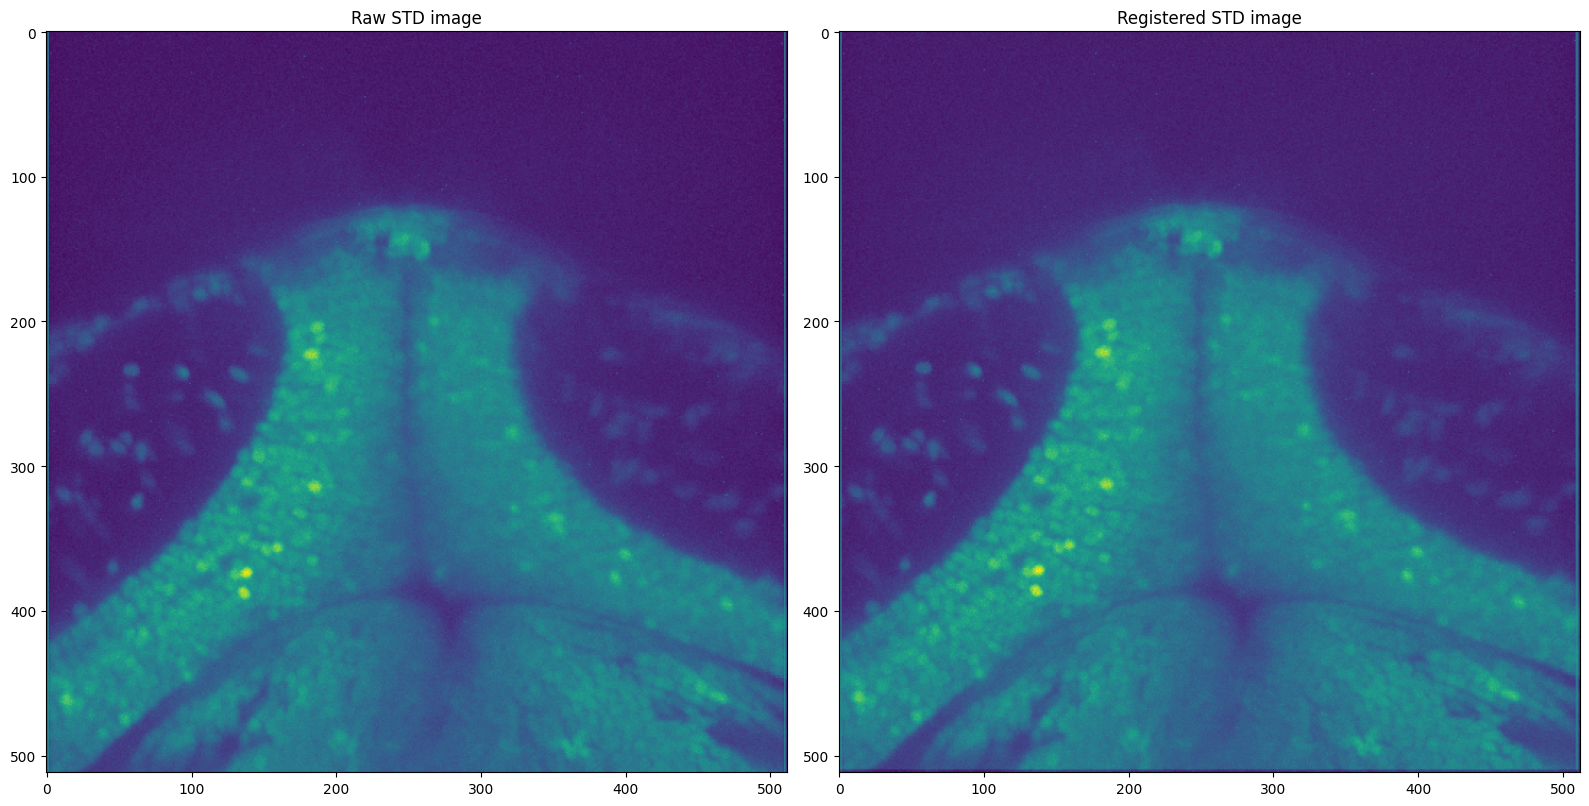

In [24]:
# registration (motion correction) of calcium frames and computation of STD image
reg_frames, std_image = motion_correction(ca_movie, binsize=100, stepsize=20)    #10, 10

## Cell Segmentation

C:\Users\timhl\PycharmProjects\preprocessing_arrenberg_practical_2022\Exp4.py:162: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  maxCoord = peak_local_max(smoothed_std_image, footprint=conn, indices=False, exclude_border=0)


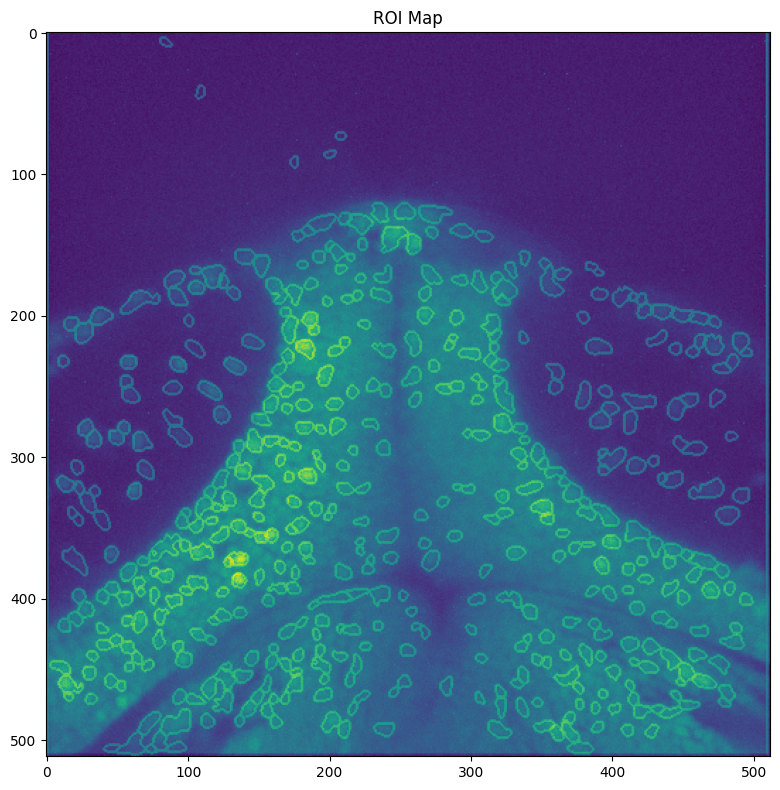

In [25]:
# cell (ROIs) segmentation with watershed algorithm
segmentation_params = {
    'hpfiltSig': .1,
    'localThreKerSize': 9,
    'smoothSig': 3,
    'binaryThre': .5,
    'minSizeLim': 20,
    'maxSizeLim': 500,
    'bgKerSize': 2,
    'fgKerSize': 1
    }
roi_mask = cell_segmentation(std_image, segmentation_params)

(473, 871)


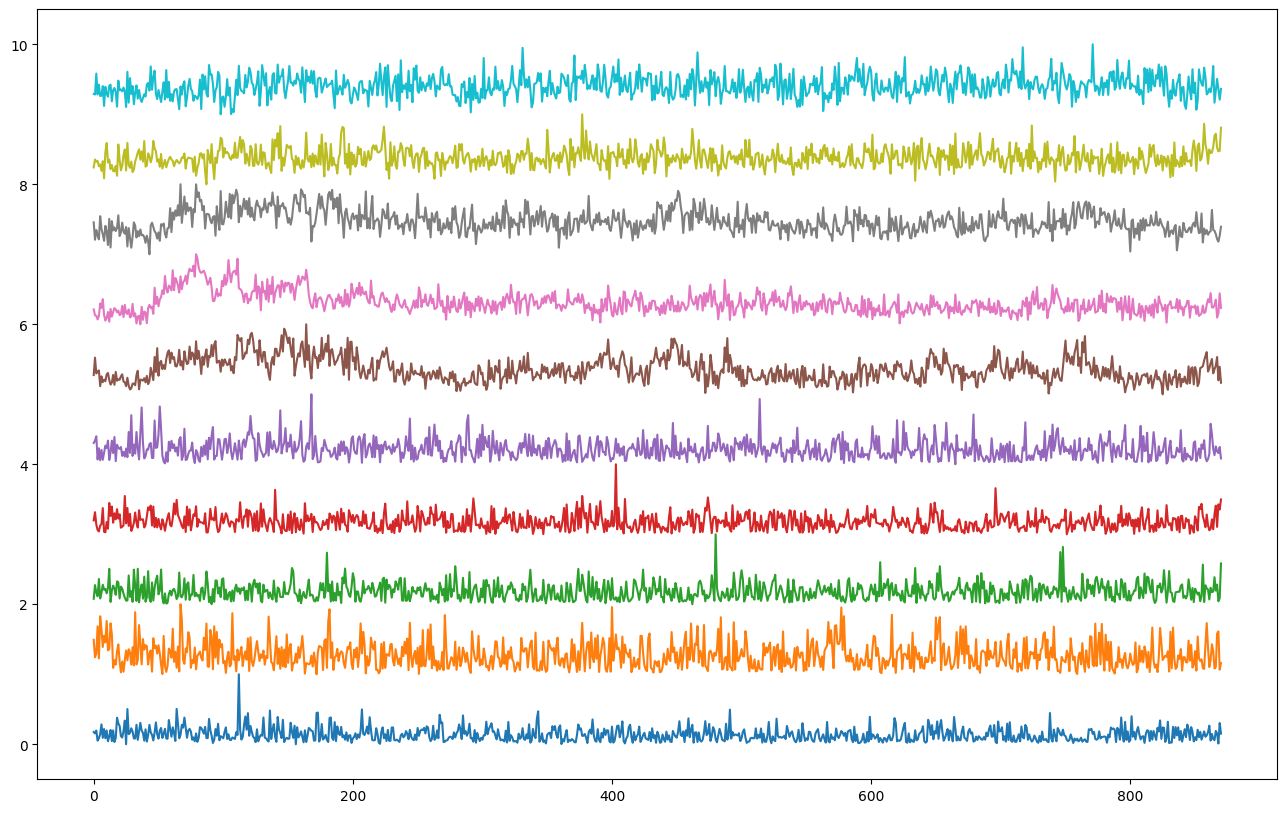

In [28]:
# extract calcium traces for ROIs
raw_ca_traces = extract_calcium_signals(roi_mask, reg_frames, display_traces=False)

# size of array
print(np.array(raw_ca_traces).shape)

plt.figure(figsize=(16, 10))
for i in range(10):
    plt.plot(rnorm(raw_ca_traces[i])+i)

## DF/F Computation
compute DF/f for each calcium trace
* Hint: $\frac{\Delta F}{F} = \frac{F(t) - F_{0}}{F_{0}}$

In [29]:
raw_ca = np.array(raw_ca_traces)
dff_ca_traces = raw_ca # put your calculation here

## Stimulus Parameter Aquisition

Text(0.5, 0, '#frames')

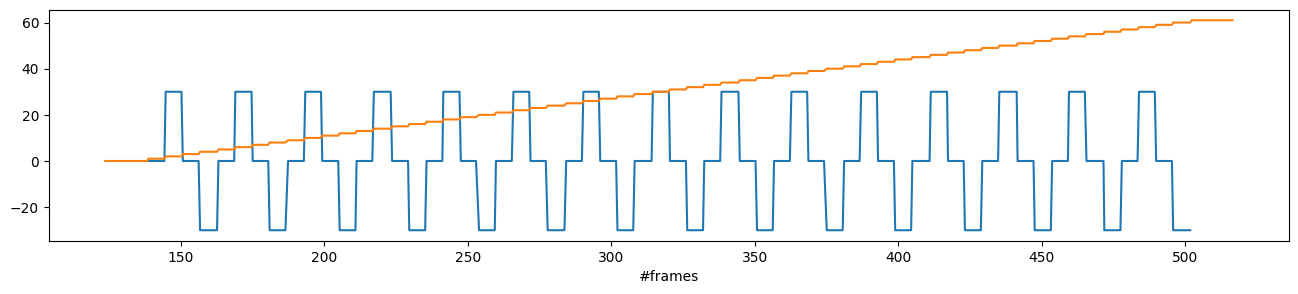

In [30]:
# acquire stimulus parameter for each calcium frames
io_file = os.path.join(working_dir, timeline_filename)
display_file = os.path.join(working_dir, stimulus_filename)
stim_array = align_stimulus_to_ca_frames(timefn=io_file,stim_fn=display_file)

# visualize
plt.figure(figsize=(16, 3))
plt.plot(stim_array['time'],stim_array['speed'])
plt.plot(stim_array['time'],stim_array['phase'])
plt.xlabel('#frames')
# plt.plot(stim_array['time'],stim_array['spatial_freq'])

In [9]:
stim_array

phase  speed  spatial_period        time
7      0.0    NaN             NaN  123.762833
8      0.0    NaN             NaN  124.235090
9      0.0    NaN             NaN  124.580138
10     0.0    NaN             NaN  125.165199
11     0.0    NaN             NaN  125.440234
..     ...    ...             ...         ...
859   61.0    NaN             NaN  514.578996
860   61.0    NaN             NaN  515.014060
861   61.0    NaN             NaN  515.489112
862   61.0    NaN             NaN  515.869154
863   61.0    NaN             NaN  516.414211

[854 rows x 4 columns]

In [31]:
# store ROIs and stimulus parameters  in one DataFrame
roi_id = np.unique(roi_mask)[1:]
formatted = pd.DataFrame(np.array(dff_ca_traces).T,columns=roi_id)
for k,v in stim_array.items():
    formatted["stim_"+k] = v
    
formatted = formatted[formatted['stim_phase'].notna()]
    
# visualize
# formatted.to_csv(working_dir + "test1.csv")
formatted

1      2      3      4      5       6       7       8       9  \
7     9409  18277  18086  25672   8193  228423  319443  287997   85542   
8    16164  23142  14596   6848  13187  240172  230727  257806   49588   
9     9057  20263  15236   6400  18406  232842  198100  325456  104843   
10   15013  29547  12131  14596  16645  264123  213727  300099  124054   
11    6784  16804  15973   9281  21991  271226  246766  238630   82885   
..     ...    ...    ...    ...    ...     ...     ...     ...     ...   
859  11299  28649  15589  20551   7072  367754  288100  306567  107634   
860  13732  17892  14660  11907   8641  277468  319217  285271   80164   
861  18758   9537   7904   8000  12290  292165  301832  297410  110387   
862   7328  12514  15974   9121  34125  316238  353987  300832  102765   
863  12386  19430  12930  16741  26761  335864  273948  397933  103437   

         10  ...     468    469     470    471     472     473  stim_phase  \
7    187820  ...  146303  33421  215257  23338  113841  318131         0.0   
8    136886  ...  146114  51574  224480  29645   72351  311757         0.0   
9    185900  ...  139165  20006  229824  54072   98635  348067         0.0   
10   168163  ...  156354  28074  213466  56986   65882  209564         0.0   
11   160769  ...  100969  37295  190413  46997   62008  249394         0.0   
..      ...  ...     ...    ...     ...    ...     ...     ...         ...   
859  166468  ...  196887  11041  195439  13284   62103  234119        61.0   
860  170535  ...  166121  18981  215354  38545  100013  314224        61.0   
861  181449  ...  102023  41489  201745  26761   73088  261815        61.0   
862  172295  ...  131158  50484  195728  60283   49042  272346        61.0   
863  192270  ...  124597  33036  224708  54741   58999  272893        61.0   

     stim_speed  stim_spatial_period   stim_time  
7           NaN                  NaN  123.762833  
8           NaN                  NaN  124.235090  
9           NaN                  NaN  124.580138  
10          NaN                  NaN  125.165199  
11          NaN                  NaN  125.440234  
..          ...                  ...         ...  
859         NaN                  NaN  514.578996  
860         NaN                  NaN  515.014060  
861         NaN                  NaN  515.489112  
862         NaN                  NaN  515.869154  
863         NaN                  NaN  516.414211  

[854 rows x 477 columns]

In [32]:
# plot some example calcium traces
plt.figure(figsize=(16, 16))
for i in range(50):
    plt.plot(formatted['stim_time'],rnorm(formatted[i+1].to_numpy())+i)
plt.xlabel('time [s]')
plt.ylabel('# ROIs')

Text(0, 0.5, '# ROIs')

## ROI Analysis

Text(0.5, 0, 'time [s]')

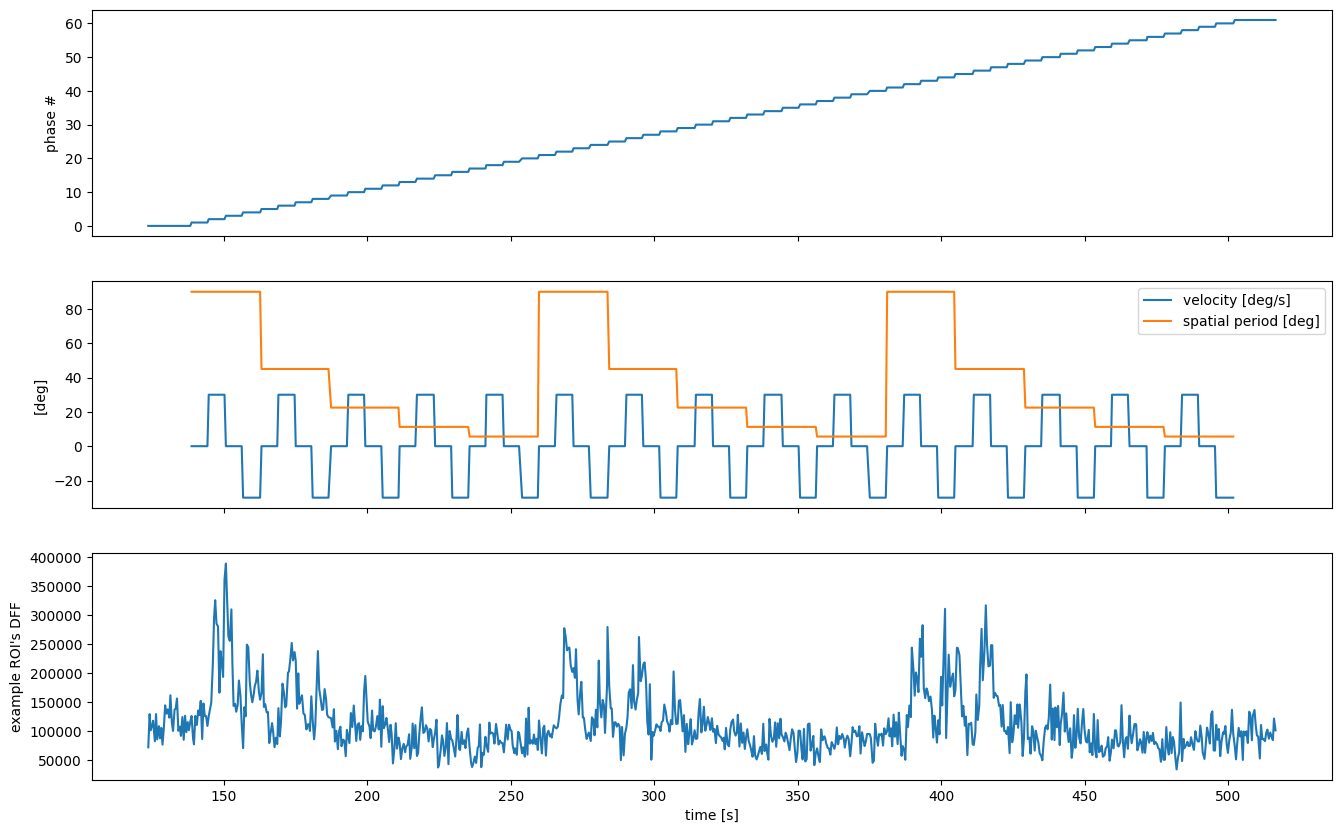

In [33]:
# visualization of stimulus phase, velocity and a example ROI
fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)
axes[0].plot(formatted['stim_time'], formatted['stim_phase'])
axes[0].set_ylabel('phase #')

axes[1].plot(formatted['stim_time'], formatted['stim_speed'], label='velocity [deg/s]')
axes[1].plot(formatted['stim_time'], formatted['stim_spatial_period'], label='spatial period [deg]')
axes[1].set_ylabel('[deg]')
axes[1].legend()

axes[2].plot(formatted['stim_time'], formatted[46])
axes[2].set_ylabel('example ROI\'s DFF')

axes[2].set_xlabel('time [s]')

### Calculate mean/sum of DFF for each stimulation phase

In [13]:
# put your calculation here

### Calculate auto-correlation between stimulus repeats

In [14]:
# put your calculation here

### Calculate correlation between DFF and stimulus regressors

$kernel = e^{\frac{-t}{\tau}}$

Text(0.5, 0, 'time [s]')

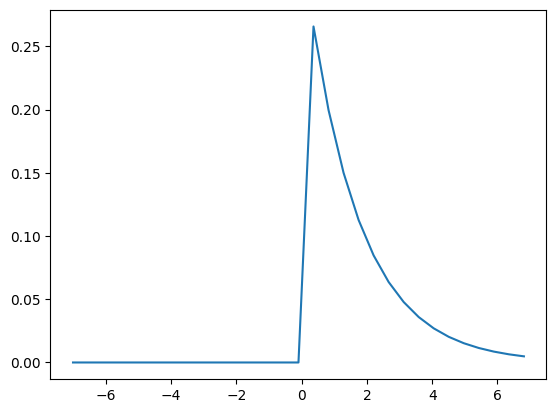

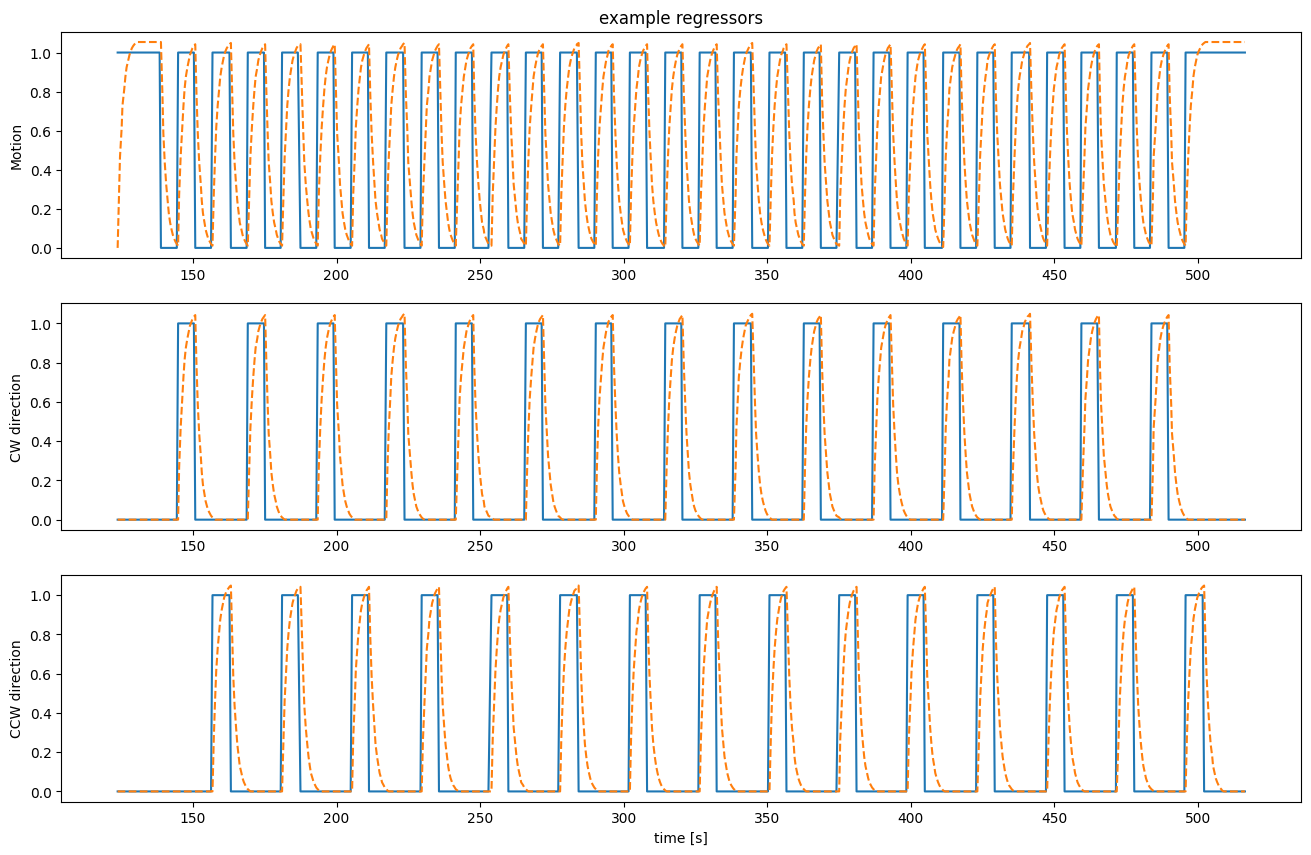

In [35]:
tau = 1.61
ca_times = formatted['stim_time']
ktimes = np.arange(-7, 7, np.mean(np.diff(ca_times)))
kernel = np.zeros_like(ktimes)
kernel[ktimes >= 0] = np.exp(-ktimes[ktimes >= 0]/tau) / 3.

plt.figure()
plt.plot(ktimes, kernel)


# example plots for different regressors
fig, axes = plt.subplots(3, 1, figsize=(16, 10))

axes[0].set_title('example regressors')

motion = (formatted['stim_speed'] != 0).astype(np.float64)
axes[0].plot(ca_times, motion)
axes[0].set_ylabel('Motion')

cw_motion = (formatted['stim_speed'] > 0).astype(np.float64)
axes[1].plot(ca_times, cw_motion)
axes[1].set_ylabel('CW direction')

ccw_motion = (formatted['stim_speed'] < 0).astype(np.float64)
axes[2].plot(ca_times, ccw_motion)
axes[2].set_ylabel('CCW direction')

axes[0].plot(ca_times, np.convolve(motion, kernel, mode='same'), '--')
axes[1].plot(ca_times, np.convolve(cw_motion, kernel, mode='same'), '--')
axes[2].plot(ca_times, np.convolve(ccw_motion, kernel, mode='same'), '--')

axes[2].set_xlabel('time [s]')

In [ ]:
# put your calculation here